In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import kerastuner as kt
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, LSTM
from sklearn import metrics

In [10]:
TrainTx = pd.read_csv('../input/type-data-nbaiot-processed/TrainTx.csv')
TrainTy = pd.read_csv('../input/type-data-nbaiot-processed/TrainTy.csv')
ValTx = pd.read_csv('../input/type-data-nbaiot-processed/ValTx.csv')
ValTy = pd.read_csv('../input/type-data-nbaiot-processed/ValTy.csv')

In [11]:
def build_model(hp):
    model = Sequential()
    counter=0
    for i in range(hp.Int('num_layers', min_value=1, max_value=5)):
        if counter == 0:
            model.add(LSTM(hp.Int('units'+str(i), min_value=8, max_value=48, step=8), activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'sigmoid']), input_shape=(TrainTx.shape[1], 1)))
        else:
            model.add(Dense(hp.Int('units'+str(i), min_value=8, max_value=48, step=8), activation=hp.Choice('activation'+str(i), values=['relu', 'tanh', 'sigmoid'])))
        counter += 1
    model.add(Dense(11, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
tuner= kt.RandomSearch(build_model, objective='val_accuracy', max_trials=5)

In [16]:
tuner.search(TrainTx, TrainTy, epochs=10, validation_data = (ValTx, ValTy))

Trial 5 Complete [00h 34m 17s]
val_accuracy: 0.8824406862258911

Best val_accuracy So Far: 0.8897944092750549
Total elapsed time: 02h 43m 45s


In [18]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48)                9600      
                                                                 
 dense (Dense)               (None, 16)                784       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 11)                99        
                                                                 
Total params: 10691 (41.76 KB)
Trainable params: 10691 (41.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
best_model.fit(TrainTx, TrainTy, initial_epoch=10, epochs = 20)

Epoch 11/20
9529/9529 [==============================] - 200s 21ms/step - loss: 0.1783 - accuracy: 0.8879
Epoch 12/20
9529/9529 [==============================] - 194s 20ms/step - loss: 0.1749 - accuracy: 0.8886
Epoch 13/20
9529/9529 [==============================] - 195s 21ms/step - loss: 0.1713 - accuracy: 0.8903
Epoch 14/20
9529/9529 [==============================] - 196s 21ms/step - loss: 0.1713 - accuracy: 0.8892
Epoch 15/20
9529/9529 [==============================] - 196s 21ms/step - loss: 0.1675 - accuracy: 0.8906
Epoch 16/20
9529/9529 [==============================] - 197s 21ms/step - loss: 0.1683 - accuracy: 0.8908
Epoch 17/20
9529/9529 [==============================] - 195s 20ms/step - loss: 0.1646 - accuracy: 0.8914
Epoch 18/20
9529/9529 [==============================] - 196s 21ms/step - loss: 0.1639 - accuracy: 0.8920
Epoch 19/20
9529/9529 [==============================] - 198s 21ms/step - loss: 0.1643 - accuracy: 0.8916
Epoch 20/20
9529/9529 [=======================

In [38]:
import pickle
with open('RNNTyrpe.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [20]:
import joblib

In [39]:
dt = {
    'RNNtype':best_model,
}
joblib.dump(dt, 'RNNType.joblib')

['RNNType.joblib']

## Accuracies

In [24]:
def accFinder(X, y):
    return metrics.accuracy_score((pd.DataFrame(best_model.predict(X))).idxmax(axis=1), y)

In [25]:
acc_card = []

In [26]:
acc_card.append(accFinder(TrainTx, TrainTy))

9529/9529 [==============================] - 73s 8ms/step


In [27]:
acc_card.append(accFinder(ValTx, ValTy))

4084/4084 [==============================] - 31s 8ms/step


In [28]:
TestTx = pd.read_csv('../input/type-data-nbaiot-processed/TestTx.csv')
TestTy = pd.read_csv('../input/type-data-nbaiot-processed/TestTy.csv')

In [29]:
acc_card.append(accFinder(TestTx, TestTy))

5835/5835 [==============================] - 44s 8ms/step


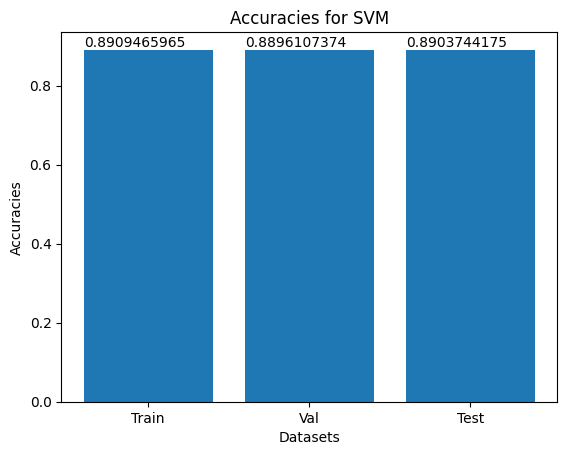

In [30]:
# Create a list of indices for the x-axis
indices = range(len(acc_card))
# Create the bar graph
bars = plt.bar(indices, acc_card)
# Optionally, you can set the labels for the x-axis to be something other than the indices
labels = ['Train', 'Val', 'Test']
plt.xticks(indices, labels)
# Labeling the axes
plt.xlabel('Datasets')
plt.ylabel('Accuracies')
# Giving a title to the graph
plt.title('Accuracies for SVM')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, '{:.10f}'.format(yval), va='bottom') # va: vertical alignment
plt.show()

## Confusion matrix

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
TestPreds = (pd.DataFrame(best_model.predict(TestTx))).idxmax(axis=1)

5835/5835 [==============================] - 44s 8ms/step


In [33]:
cm = pd.DataFrame(confusion_matrix(pd.DataFrame(TestPreds), TestTy, labels=[0,1,2,3,4,5,6,7,8,9,10]))
cm

,0,1,2,3,4,5,6,7,8,9,10
0,18607,8,11,41,14,6,6,0,5,5,0
1,5,18214,891,5,1,0,1,0,2,1,0
2,0,347,8361,2,0,0,0,1,2,1,1
3,21,9,8,9359,1,15,0,26,0,0,1
4,2,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,18629,18656,1,0,2,0,2
6,0,0,0,0,0,0,18498,0,1,1,10
7,2,0,0,4,0,0,0,18819,17,0,0
8,1,5,1,0,0,0,0,0,18682,1,0
9,1,0,2,0,0,0,62,0,0,18385,70


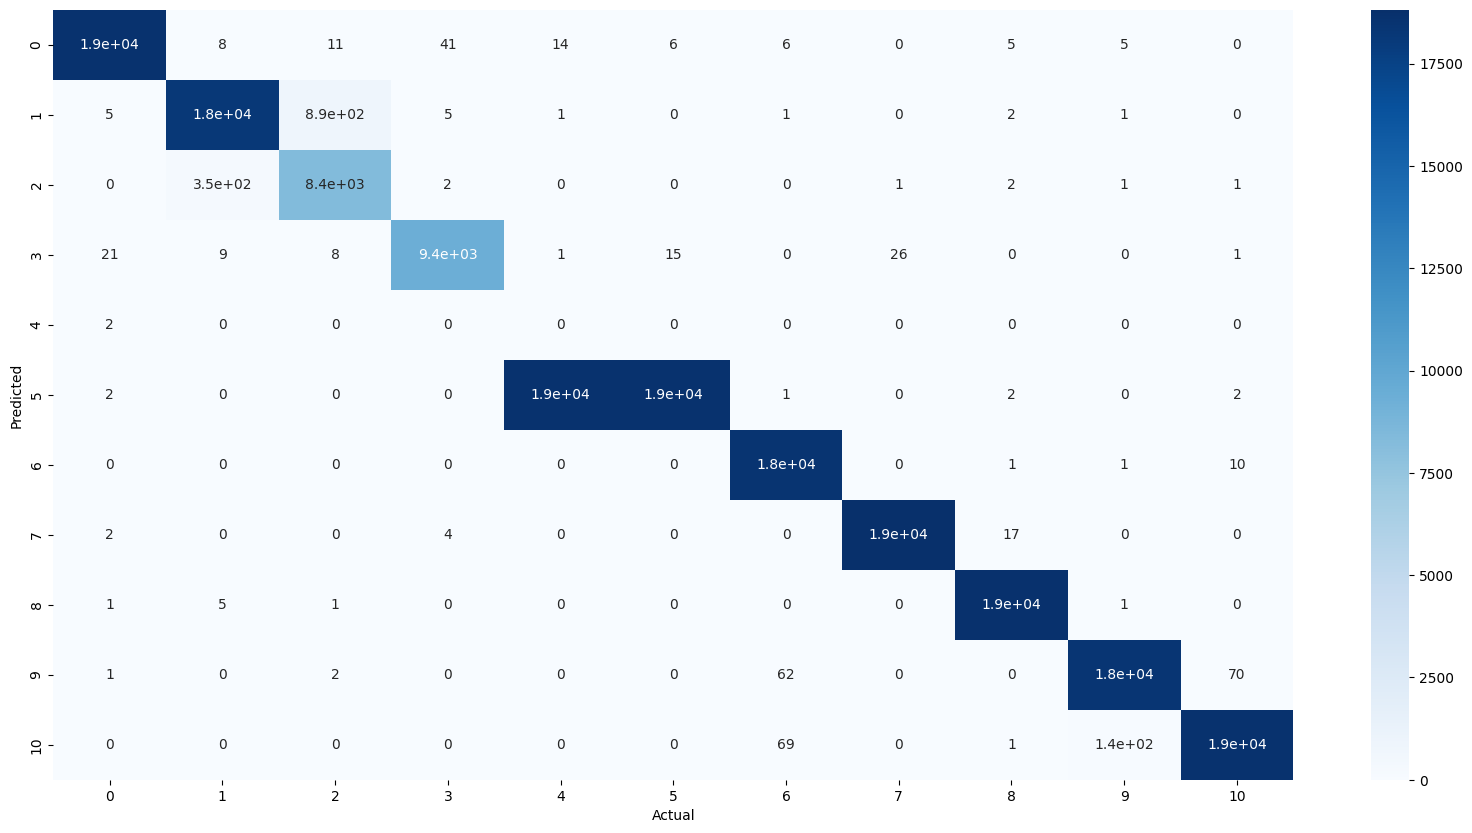

In [34]:
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [35]:
def recall(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = confMat[type][type]
    total = 0
    for i in range(len(labels)):
        total += confMat[i][type]
    return true/total

def precision(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = confMat[type][type]
    total = 0
    for i in range(len(labels)):
        total += confMat[type][i]
    return true/total

def specificity(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = 0
    for i in range(len(labels)):
        if(i==type):
            continue;
        true += confMat[i][i]
    total = 0
    for j in range(len(labels)):
        if(j==type):
            continue
        for i in range(len(labels)):
            total += confMat[i][j]
    return true/total

In [36]:
labels=range(11)

In [37]:
for i in range(len(labels)):
    print('recall of class '+str(i)+': '+str(recall(i, TestPreds, TestTy, labels)))
for i in range(len(labels)):
    print('precision of class '+str(i)+': '+str(precision(i, TestPreds, TestTy, labels)))
for i in range(len(labels)):
    print('specificity of class '+str(i)+': '+str(specificity(i, TestPreds, TestTy, labels)))

recall of class 0: 0.9981760635159058
recall of class 1: 0.9801431415810149
recall of class 2: 0.9015527280569333
recall of class 3: 0.9944745510572734
recall of class 4: 0.0
recall of class 5: 0.9988756224233014
recall of class 6: 0.9925417180876751
recall of class 7: 0.998567335243553
recall of class 8: 0.998396750748183
recall of class 9: 0.9918001834169499
recall of class 10: 0.9955144977839483
precision of class 0: 0.9948671336149281
precision of class 1: 0.9526150627615063
precision of class 2: 0.959380378657487
precision of class 3: 0.9914194915254237
precision of class 4: 0.0
precision of class 5: 0.5002681540276736
precision of class 6: 0.9993517017828201
precision of class 7: 0.9987793227895128
precision of class 8: 0.9995719636169075
precision of class 9: 0.9927105831533477
precision of class 10: 0.9887038608400509
specificity of class 0: 0.8784164142601265
specificity of class 1: 0.8804511412374262
specificity of class 2: 0.889790097849123
specificity of class 3: 0.88484817